In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

np.random.seed(48)

### Loading and preparing data

In [2]:
def preprocess_sex(xs):
    """
    The feature "Sex & Marital Status" has the following values (view documentation):
    1: male divorced/seperated
    2: female divorced seperated
    3: male single
    4: male married/widowed
    (5: female single)

    Since this is stupid we will change the feature to Sex only:
    -1: male
    1: female
    """
    xs.rename(columns={"Sex & Marital Status":"Sex"}, inplace=True)
    xs.loc[ xs["Sex"] == 1, "Sex"] = -1
    xs.loc[ xs["Sex"] == 3, "Sex"] = -1
    xs.loc[ xs["Sex"] == 4, "Sex"] = -1
    xs.loc[ xs["Sex"] == 2, "Sex"] = 1
    return xs

def read_data():
    # penn state university .csv file
    data = pd.read_csv("data/german credit/german_credit.csv")
    # shuffle data (along rows)
    data = data.sample(frac=1, random_state=49).reset_index(drop=True)

    xs = data.drop(["Creditability"], axis=1)
    xs = preprocess_sex(xs)
    ys = data["Creditability"]
    
    return xs, ys

xs, ys = read_data()
print("Class mean of Account Balance:", np.mean([1,2,3,4]))
print("Data mean of Account Balance:", np.mean(xs["Account Balance"].values))

Class mean of Account Balance: 2.5
Data mean of Account Balance: 2.577


In [3]:
def create_missingness(df, col_name, vals, freq, missingness_val):
    """
    Create new class of people not giving the voluntary feature.
    An additional column will be created, to encode missingness of a feature (0=not missing, 1=missing)
    Input: pd dataframe df, column name feature as string
    Output: pd dataframe of shape, with additional feature class
    
    args: df=pd dataframe, col_name=string of column, vals=list of values the feature can take, freq=list of change frequencies (must be of same length as vals)
    """
    df_copy = df.copy(deep=True)
    pd.set_option('mode.chained_assignment', None) #prevent unnecessary warning

    # Create dummy column to encode missingness
    df_copy[col_name + " Missing"] = df_copy[col_name].apply(lambda x: 0)
    
    if missingness_val == "all":
        df_rand = df_copy.copy(deep=True)
        df_class = df_copy.copy(deep=True)
        df_data = df_copy.copy(deep=True)
        
    for i in range(len(vals)):
        #Set number of instances of that particlar value to be replaced
        num_vol = int(df_copy[col_name].value_counts()[vals[i]] * freq[i])
        #print(vals[i], ":", num_vol)
        
        # Replace by missingness value
        idx = df_copy[col_name][(df_copy[col_name] == vals[i])].iloc[:num_vol].index
        if missingness_val == "random":
            df_copy[col_name].iloc[idx] = np.random.choice(vals)
            df_copy[col_name + " Missing"].iloc[idx] = 1
        elif missingness_val == "class_avg":
            df_copy[col_name].iloc[idx] = np.mean(vals)
            df_copy[col_name + " Missing"].iloc[idx] = 1
        elif missingness_val == "data_avg":
            df_copy[col_name].iloc[idx] = np.mean(df_copy[col_name].values)
            df_copy[col_name + " Missing"].iloc[idx] = 1
        elif missingness_val == "all":
            idx_rand = df_rand[col_name][(df_rand[col_name] == vals[i])].iloc[:num_vol].index
            idx_class = df_class[col_name][(df_class[col_name] == vals[i])].iloc[:num_vol].index
            idx_data = df_data[col_name][(df_data[col_name] == vals[i])].iloc[:num_vol].index
        
            df_rand[col_name].iloc[idx_rand] = np.random.choice(vals)
            df_class[col_name].iloc[idx_class] = np.mean(vals)
            df_data[col_name].iloc[idx_data] = np.mean(df_copy[col_name].values)
            
            df_rand[col_name + " Missing"].iloc[idx_rand] = 1
            df_class[col_name + " Missing"].iloc[idx_class] = 1
            df_data[col_name + " Missing"].iloc[idx_data] = 1
    
    if missingness_val != "all":
        return df_copy
    else:
        return df_rand, df_class, df_data

xs_acc = create_missingness(df=xs, col_name="Account Balance", vals=[1,2,3,4], freq=[0.9,0.1,0,0], missingness_val="class_avg")
xs_sex = create_missingness(df=xs, col_name="Sex", vals=[-1, 1], freq=[0, 0.9], missingness_val="class_avg")
xs_acc_unaware = xs_acc.drop("Account Balance Missing", axis=1)
xs_sex_unaware = xs_sex.drop("Sex Missing", axis=1)
xs_acc_dropped = xs.drop("Account Balance", axis=1)
xs_sex_dropped = xs.drop("Sex", axis=1)
#print(xs_acc["Account Balance Missing"].value_counts())
#print(xs_acc["Account Balance"].value_counts())
#display(xs_acc)
xs_rand, xs_class, xs_data = create_missingness(df=xs, col_name="Account Balance", vals=[1,2,3,4], freq=[0,0.2,0.2,0.2], missingness_val="all")
#display(xs_class)
print(xs_class["Account Balance Missing"].value_counts())

0    857
1    143
Name: Account Balance Missing, dtype: int64


In [4]:
# normalize data along feature axis (min-max-scaling)
def min_max_scaling(data):
    return (data - data.min()) / (data.max() - data.min())

xs = min_max_scaling(xs)
xs_acc = min_max_scaling(xs_acc)
xs_sex = min_max_scaling(xs_sex)
xs_acc_unaware = min_max_scaling(xs_acc_unaware)
xs_sex_unaware = min_max_scaling(xs_sex_unaware)
xs_acc_dropped = min_max_scaling(xs_acc_dropped)
xs_sex_dropped = min_max_scaling(xs_sex_dropped)

### Logistic regression

In [5]:
# logistic regression on all features
log_reg = LogisticRegression()
cross_val = cross_validate(log_reg, xs.values, ys.values, cv=10, return_estimator=True)
accuracy = np.mean(cross_val["test_score"])
print("Accuracy including voluntary feature:", accuracy)

# logistic regression with missingness (Account Balance)
log_reg_acc = LogisticRegression() #penalty="none", solver="newton-cg"
cross_val_acc = cross_validate(log_reg_acc, xs_acc.values, ys.values, cv=10, return_estimator=True)
accuracy_acc = np.mean(cross_val_acc["test_score"])
print("Accuracy with missingness acc:", accuracy_acc)

# logistic regression with missingness (Sex)
log_reg_sex = LogisticRegression()
cross_val_sex = cross_validate(log_reg_sex, xs_sex.values, ys.values, cv=10, return_estimator=True)
accuracy_sex = np.mean(cross_val_sex["test_score"])
print("Accuracy with missingness sex:", accuracy_sex)

# logistic regression with missingness (Account Balance) --unaware
log_reg_acc_unaware = LogisticRegression() #penalty="none", solver="newton-cg"
cross_val_acc_unaware = cross_validate(log_reg_acc_unaware, xs_acc_unaware.values, ys.values, cv=10, return_estimator=True)
accuracy_acc_unaware = np.mean(cross_val_acc_unaware["test_score"])
print("Accuracy with missingness acc (unaware):", accuracy_acc_unaware)

# logistic regression with missingness (Sex) --unaware
log_reg_sex_unaware = LogisticRegression()
cross_val_sex_unaware = cross_validate(log_reg_sex_unaware, xs_sex_unaware.values, ys.values, cv=10, return_estimator=True)
accuracy_sex_unaware = np.mean(cross_val_sex_unaware["test_score"])
print("Accuracy with missingness sex (unaware):", accuracy_sex_unaware)

# logistic regression with missingness (Account Balance) --dropped
log_reg_acc_dropped = LogisticRegression() #penalty="none", solver="newton-cg"
cross_val_acc_dropped = cross_validate(log_reg_acc_dropped, xs_acc_dropped.values, ys.values, cv=10, return_estimator=True)
accuracy_acc_dropped = np.mean(cross_val_acc_dropped["test_score"])
print("Accuracy with missingness acc (dropped):", accuracy_acc_dropped)

# logistic regression with missingness (Sex) --dropped
log_reg_sex_dropped = LogisticRegression()
cross_val_sex_dropped = cross_validate(log_reg_sex_dropped, xs_sex_dropped.values, ys.values, cv=10, return_estimator=True)
accuracy_sex_dropped = np.mean(cross_val_sex_dropped["test_score"])
print("Accuracy with missingness sex (dropped):", accuracy_sex_dropped)

# Print coefficients
#for i in range(len(xs.columns)):
#    print(xs.columns[i] + ": " + str(log_reg.coef_[0][i]) )
#print(log_reg_acc.coef_[0][xs_acc.columns.get_loc("Account Balance Missing")])

temp = []
for model in cross_val["estimator"]:
    temp.append(model.coef_[0])
coefs = np.mean(np.array(temp), axis=0)

max_coef_idx = np.absolute(coefs).argmax()
print("Highest coefficient of regression on full dataset:", xs.columns[max_coef_idx], ", with ", coefs[max_coef_idx])

Accuracy including voluntary feature: 0.761
Accuracy with missingness acc: 0.76
Accuracy with missingness sex: 0.759
Accuracy with missingness acc (unaware): 0.765
Accuracy with missingness sex (unaware): 0.765
Accuracy with missingness acc (dropped): 0.7380000000000001
Accuracy with missingness sex (dropped): 0.7550000000000001
Highest coefficient of regression on full dataset: Account Balance , with  1.6780247990076251


### Plot some stuff

'\nvisualize_coefs(cross_val=cross_val_sex, indicators=xs_sex.columns.values, title="Sex Missing")\nvisualize_coefs(cross_val=cross_val_acc_unaware, indicators=xs_acc_unaware.columns.values, title="Account Balance Missing (unaware)")\nvisualize_coefs(cross_val=cross_val_sex_unaware, indicators=xs_sex_unaware.columns.values, title="Sex Missing (unaware)")\nvisualize_coefs(cross_val=cross_val_acc_dropped, indicators=xs_acc_dropped.columns.values, title="Account Balance dropped")\nvisualize_coefs(cross_val=cross_val_sex_dropped, indicators=xs_sex_dropped.columns.values, title="Sex dropped")\n'

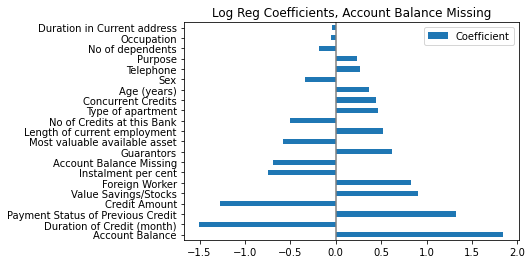

In [6]:
def visualize_coefs(cross_val, indicators, title):
    col_name = "Account Balance"
    temp = []
    for model in cross_val["estimator"]:
        temp.append(model.coef_[0])
    coefs = np.mean(np.array(temp), axis=0)
    coef_df = pd.DataFrame(coefs, columns=["Coefficient"], index=indicators)
    coef_df.sort_values("Coefficient", inplace=True, key=abs, ascending=False)
    
    title = "Log Reg Coefficients, " + title
    coef_df.iloc[:,:].plot(kind="barh")
    plt.axvline(x=0, color="grey")
    plt.title(title)
    #plt.show()
    plt.savefig("plots/log_reg_coefs.png", dpi=250, bbox_inches="tight")

#visualize_coefs(cross_val=cross_val, indicators=xs.columns.values, title="No Missingness")

# uncomment to print coefficients of other models

visualize_coefs(cross_val=cross_val_acc, indicators=xs_acc.columns.values, title="Account Balance Missing")
"""
visualize_coefs(cross_val=cross_val_sex, indicators=xs_sex.columns.values, title="Sex Missing")
visualize_coefs(cross_val=cross_val_acc_unaware, indicators=xs_acc_unaware.columns.values, title="Account Balance Missing (unaware)")
visualize_coefs(cross_val=cross_val_sex_unaware, indicators=xs_sex_unaware.columns.values, title="Sex Missing (unaware)")
visualize_coefs(cross_val=cross_val_acc_dropped, indicators=xs_acc_dropped.columns.values, title="Account Balance dropped")
visualize_coefs(cross_val=cross_val_sex_dropped, indicators=xs_sex_dropped.columns.values, title="Sex dropped")
"""

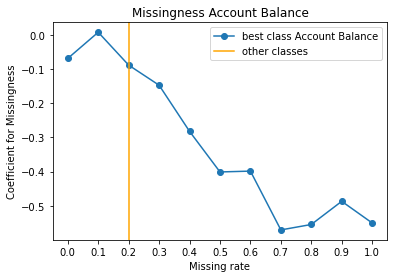

In [7]:
def missingness_vs_coefs(col_name, vals, freq, missingness_val, vol_idx, num_samples):
    if missingness_val == "all":
        print("wrong missingness_val")
        return -1
    
    # reading in data again is necessary because function "create missingness" needs un-normalized data
    xs, ys = read_data()
    accuracies = []
    missingness_coefs = []
    
    for i in range(num_samples):
        sample_missingness_coefs = []
        for i in range(0, 11):
            missing_rate = i/10
            freq[vol_idx] = missing_rate
            xs_vol = create_missingness(xs, col_name, vals, freq, missingness_val)
            xs_vol = min_max_scaling(xs_vol)
            log_reg_vol = LogisticRegression()
            cross_val = cross_validate(log_reg_vol, xs_vol.values, ys.values, cv=10, return_estimator=True)
            accuracy = np.mean(cross_val["test_score"])
            accuracies.append(accuracy)
            temp = []
            for model in cross_val["estimator"]:
                temp.append(model.coef_[0][xs_vol.columns.get_loc(col_name + " Missing")])
            missingness_coef = np.mean(temp)
            sample_missingness_coefs.append(np.array(missingness_coef))
        missingness_coefs.append(np.array(sample_missingness_coefs))

        
    missingness_coefs = np.mean(missingness_coefs, axis=0)
    plt.plot(np.linspace(0, 1, 11), missingness_coefs, 'o-', label='best class '+col_name)
    plt.axvline(0.2, color="orange", label="other classes")
    plt.xlabel("Missing rate")
    plt.ylabel("Coefficient for Missingness")
    plt.xticks(np.linspace(0, 1, 11))
    plt.legend(loc='best')
    plt.title("Missingness Account Balance")
    #plt.show()
    plt.savefig("plots/coefficient_vs_frequencies.png", dpi=150)

missingness_vs_coefs(col_name="Account Balance", vals=[1,2,3,4], freq=[0.2,0.2,0.2,0.2], missingness_val="class_avg", vol_idx=0, num_samples=1)

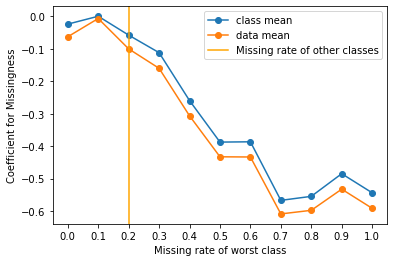

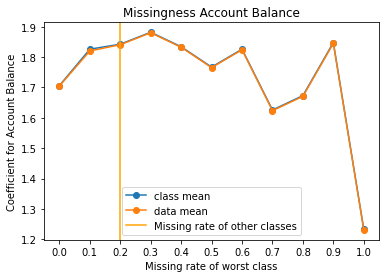

[0.00146853 0.00582764 0.00173577 0.00165934 0.00167666 0.00180537
 0.00196055 0.00216974 0.00246754 0.0028113  0.0024508 ]


In [8]:
def missingness_vs_coefs_all(col_name, vals, freq, missingness_val, vol_idx, num_samples):
    if missingness_val != "all":
        print("wrong missingness_val")
        return -1
    
    # reading in data again is necessary because function "create missingness" needs un-normalized data
    xs, ys = read_data()

    missingness_coefs_rand = []
    missingness_coefs_class = []
    missingness_coefs_data = []
    acc_coefs_rand = []
    acc_coefs_class = []
    acc_coefs_data = []
    
    for i in range(num_samples):
        sample_missingness_coefs_rand = []
        sample_missingness_coefs_class = []
        sample_missingness_coefs_data = []
        sample_acc_coefs_rand = []
        sample_acc_coefs_class = []
        sample_acc_coefs_data = []
        
        for i in range(0, 11):
            missing_rate = i/10
            freq[vol_idx] = missing_rate
            xs_rand, xs_class, xs_data = create_missingness(xs, col_name, vals, freq, missingness_val)
            xs_rand, xs_class, xs_data = min_max_scaling(xs_rand), min_max_scaling(xs_class), min_max_scaling(xs_data)
            log_reg_rand, log_reg_class, log_reg_data = LogisticRegression(penalty="l1", solver="liblinear"), LogisticRegression(penalty="l1", solver="liblinear"), LogisticRegression(penalty="l1", solver="liblinear")
            cross_val_rand, cross_val_class, cross_val_data = [cross_validate(log_reg_rand, xs_rand.values, ys.values, cv=10, return_estimator=True),
                                                               cross_validate(log_reg_class, xs_class.values, ys.values, cv=10, return_estimator=True),
                                                               cross_validate(log_reg_data, xs_data.values, ys.values, cv=10, return_estimator=True)]
            temp_m = []
            temp_a = []
            for model in cross_val_rand["estimator"]:
                temp_m.append(model.coef_[0][xs_rand.columns.get_loc(col_name + " Missing")])
                temp_a.append(model.coef_[0][xs_rand.columns.get_loc(col_name)])
            missingness_coef_rand = np.mean(temp_m)
            acc_coef_rand = np.mean(temp_a)
            temp_m = []
            temp_a = []
            for model in cross_val_class["estimator"]:
                temp_m.append(model.coef_[0][xs_rand.columns.get_loc(col_name + " Missing")])
                temp_a.append(model.coef_[0][xs_rand.columns.get_loc(col_name)])            
            missingness_coef_class = np.mean(temp_m)
            acc_coef_class = np.mean(temp_a)            
            temp_m = []
            temp_a = []
            for model in cross_val_data["estimator"]:
                temp_m.append(model.coef_[0][xs_rand.columns.get_loc(col_name + " Missing")])
                temp_a.append(model.coef_[0][xs_rand.columns.get_loc(col_name)])            
            missingness_coef_data = np.mean(temp_m)
            acc_coef_data = np.mean(temp_a) 
            
            sample_missingness_coefs_rand.append(np.array(missingness_coef_rand))
            sample_missingness_coefs_class.append(np.array(missingness_coef_class))
            sample_missingness_coefs_data.append(np.array(missingness_coef_data))
            sample_acc_coefs_rand.append(np.array(acc_coef_rand))
            sample_acc_coefs_class.append(np.array(acc_coef_class))
            sample_acc_coefs_data.append(np.array(acc_coef_data))
            
        missingness_coefs_rand.append(np.array(sample_missingness_coefs_rand))
        missingness_coefs_class.append(np.array(sample_missingness_coefs_class))
        missingness_coefs_data.append(np.array(sample_missingness_coefs_data))
        acc_coefs_rand.append(np.array(sample_acc_coefs_rand))
        acc_coefs_class.append(np.array(sample_acc_coefs_class))
        acc_coefs_data.append(np.array(sample_acc_coefs_data))
        
    missingness_coefs_rand = np.mean(missingness_coefs_rand, axis=0)
    missingness_coefs_class = np.mean(missingness_coefs_class, axis=0)
    missingness_coefs_data = np.mean(missingness_coefs_data, axis=0)
    acc_coefs_rand = np.mean(acc_coefs_rand, axis=0)
    acc_coefs_class = np.mean(acc_coefs_class, axis=0)
    acc_coefs_data = np.mean(acc_coefs_data, axis=0)
    
    #plt.plot(np.linspace(0, 1, 11), missingness_coefs_rand, 'o-', label='worst class '+ col_name + " (random)")
    plt.plot(np.linspace(0, 1, 11), missingness_coefs_class, 'o-', label="class mean")
    plt.plot(np.linspace(0, 1, 11), missingness_coefs_data, 'o-', label="data mean")
    plt.axvline(0.2, color="orange", label="Missing rate of other classes")
    plt.xlabel("Missing rate of worst class")
    plt.ylabel("Coefficient for Missingness")
    plt.xticks(np.linspace(0, 1, 11))
    plt.legend(loc='best')
    #plt.title("Missingness Account Balance")
    plt.savefig("plots/coefficient_vs_frequencies.png", dpi=250)
    plt.show()
    
    plt.plot(np.linspace(0, 1, 11), acc_coefs_class, 'o-', label="class mean")
    plt.plot(np.linspace(0, 1, 11), acc_coefs_data, 'o-', label="data mean")
    plt.axvline(0.2, color="orange", label="Missing rate of other classes")
    plt.xlabel("Missing rate of worst class")
    plt.ylabel("Coefficient for Account Balance")
    plt.xticks(np.linspace(0, 1, 11))
    plt.legend(loc='best')
    plt.title("Missingness Account Balance")
    plt.show()
    print(acc_coefs_class - acc_coefs_data)

missingness_vs_coefs_all(col_name="Account Balance", vals=[1,2,3,4], freq=[0.2,0.2,0.2,0.2], missingness_val="all", vol_idx=0, num_samples=1)

### Decision trees

Accuracy without missingness: 0.731
Accuracy with Account Balance missing: 0.732
Accuracy with Account Balance missing (unaware): 0.732
Accuracy with Account Balance dropped: 0.711


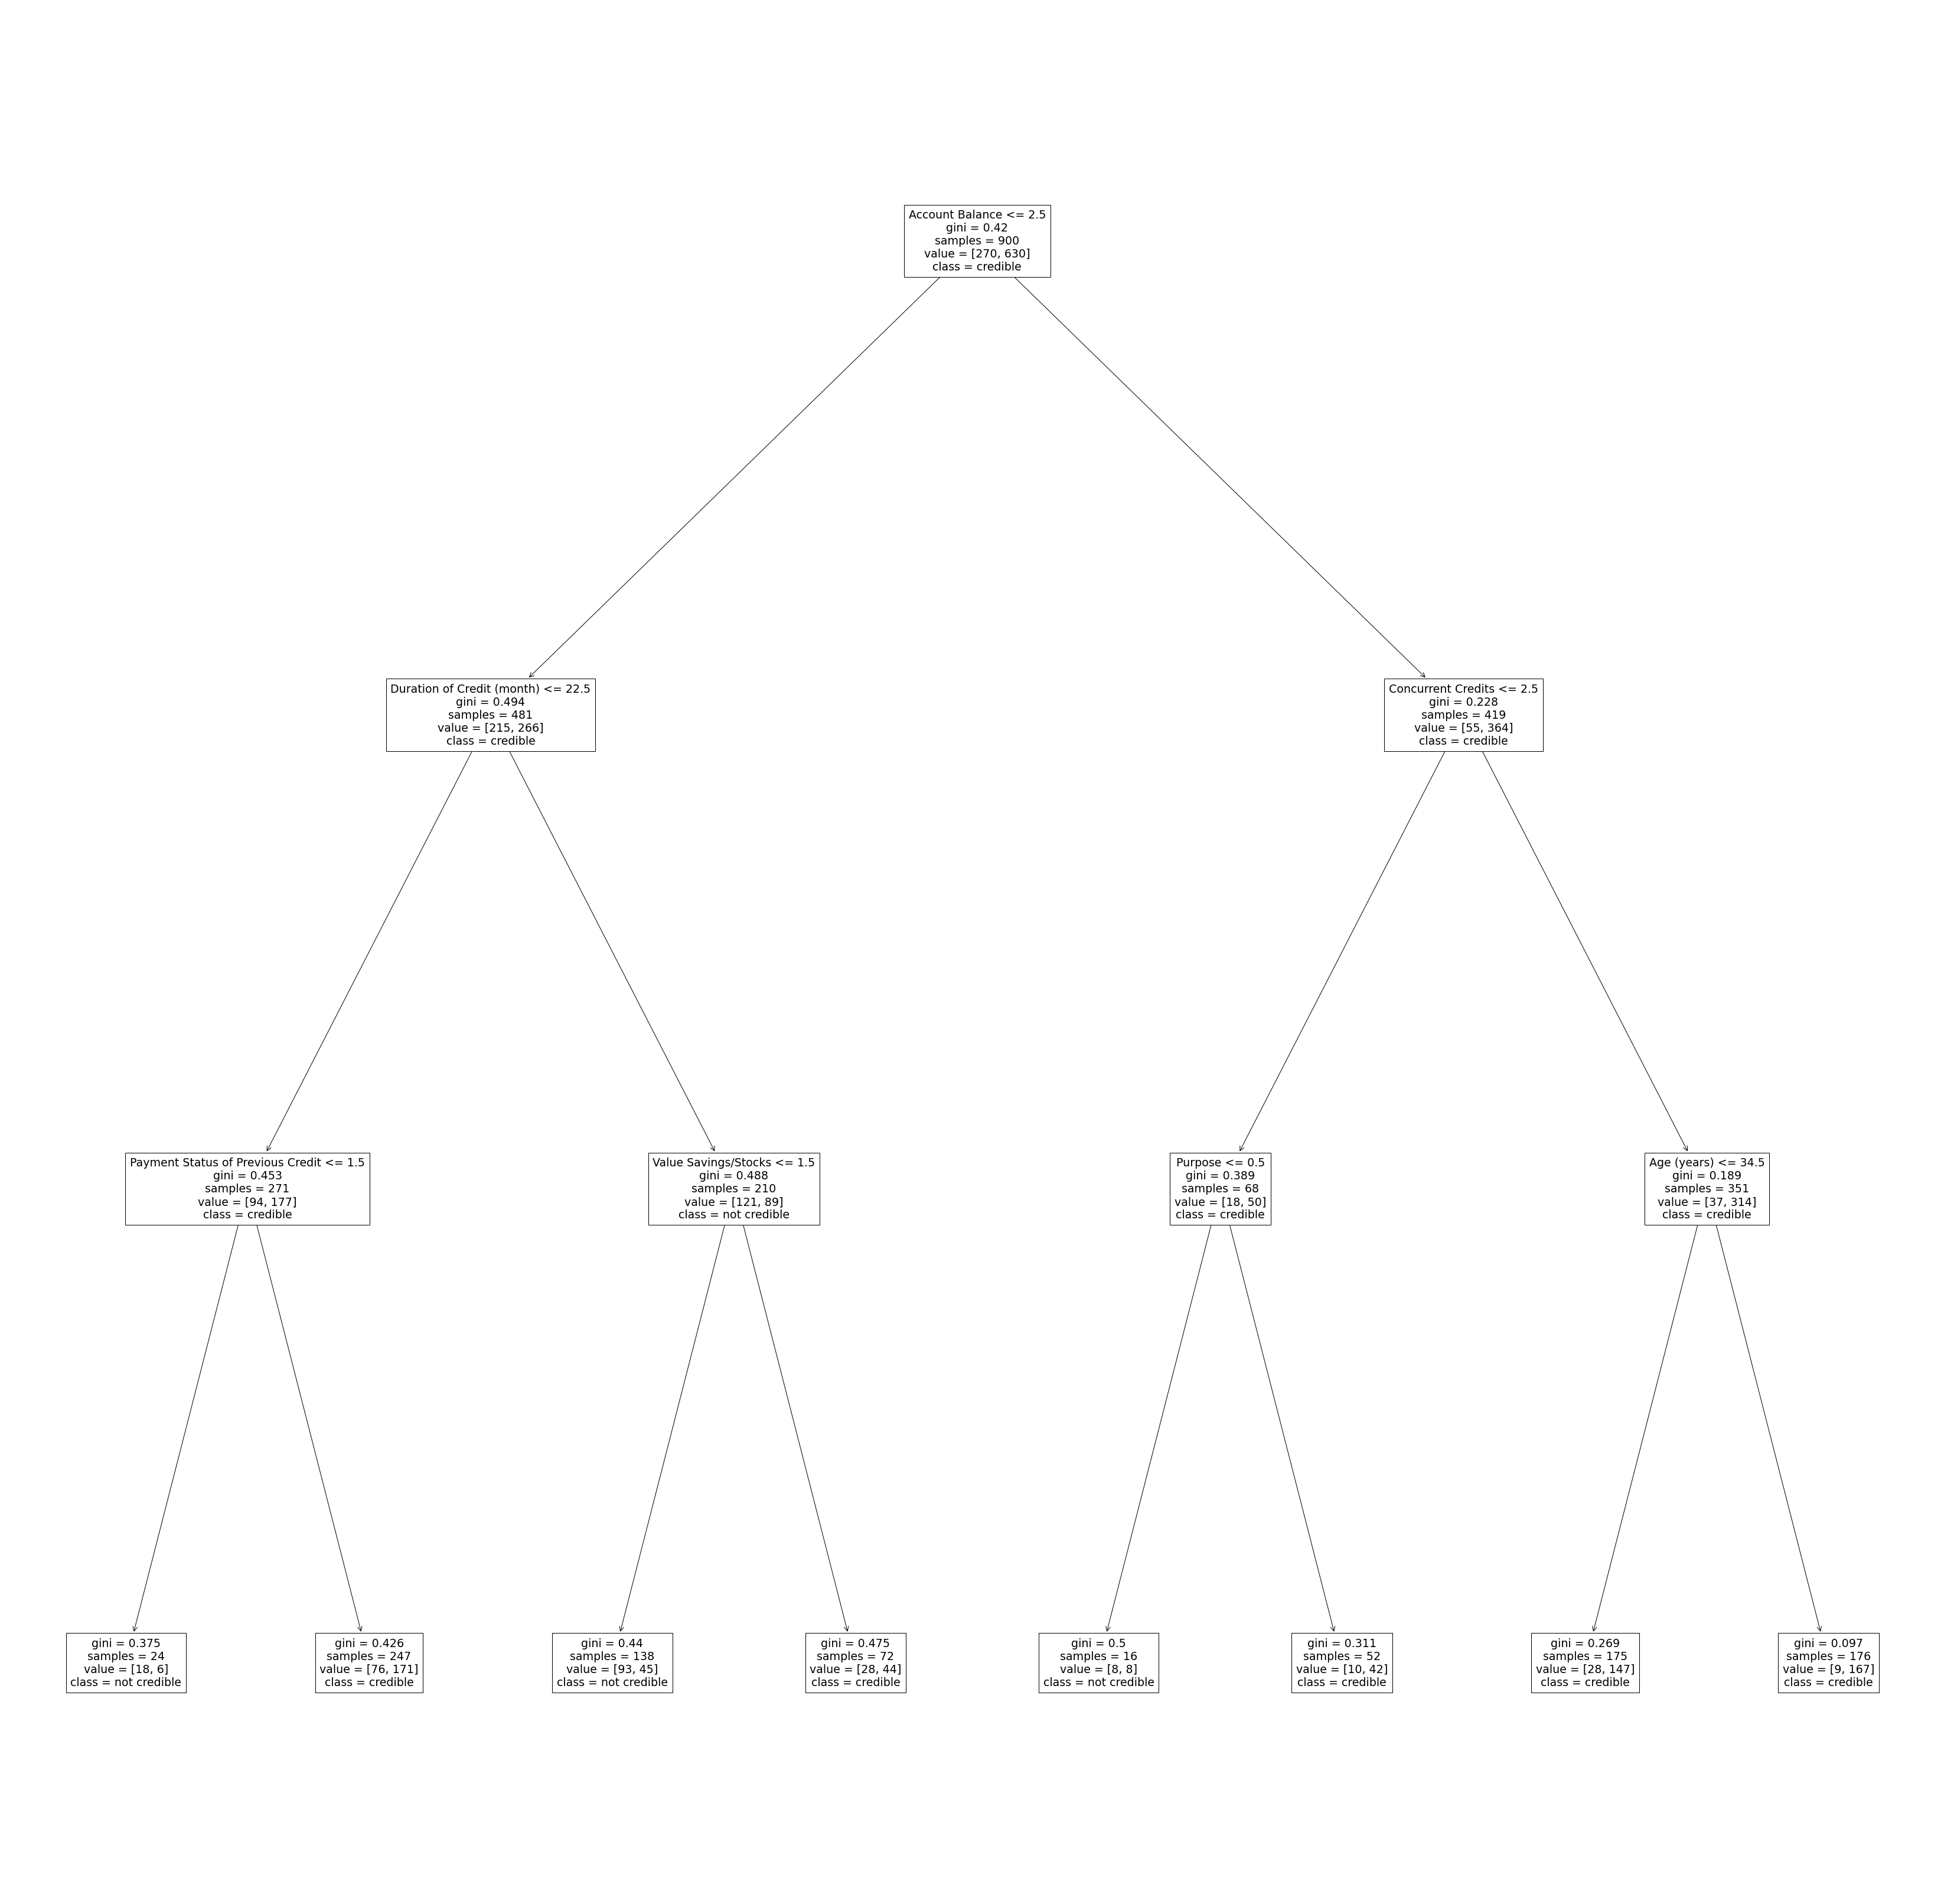

2.25

In [23]:
# read in data again to have unnormalized data
xs, ys = read_data()
xs_acc_dropped = xs.drop("Account Balance", axis=1)
xs_acc = create_missingness(df=xs, col_name="Account Balance", vals=[1,2,3,4], freq=[0.2,0.2,0.2,0.2], missingness_val="class_avg")
xs_acc_unaware = xs_acc.drop("Account Balance Missing", axis=1)

d_tree = DecisionTreeClassifier(max_depth = 3, random_state=42)
cross_val = cross_validate(d_tree, xs.values, ys.values, cv=10, return_estimator=True)
accuracy = np.mean(cross_val["test_score"])
print("Accuracy without missingness:", accuracy)

d_tree_acc = DecisionTreeClassifier(max_depth = 3, random_state=42)
cross_val_acc = cross_validate(d_tree_acc, xs_acc.values, ys.values, cv=10, return_estimator=True)
accuracy_acc = np.mean(cross_validate(d_tree_acc, xs_acc.values, ys.values, cv=10)["test_score"])
print("Accuracy with Account Balance missing:", accuracy_acc)

d_tree_acc_unaware = DecisionTreeClassifier(max_depth = 3, random_state=42)
cross_val_acc_unaware = cross_validate(d_tree_acc_unaware, xs_acc_unaware.values, ys.values, cv=10, return_estimator=True)
accuracy_acc_unaware = np.mean(cross_val_acc_unaware["test_score"])
print("Accuracy with Account Balance missing (unaware):", accuracy_acc_unaware)

d_tree_acc_dropped = DecisionTreeClassifier(max_depth = 3, random_state=42)
cross_val_acc_dropped = cross_validate(d_tree_acc_dropped, xs_acc_dropped.values, ys.values, cv=10, return_estimator=True)
accuracy_acc_dropped = np.mean(cross_val_acc_dropped["test_score"])
print("Accuracy with Account Balance dropped:", accuracy_acc_dropped)

def cm_to_inch(value):
    return value/2.54

from sklearn import tree
plt.figure(figsize=(cm_to_inch(150), cm_to_inch(150)))
tree.plot_tree(cross_val["estimator"][0], feature_names=xs.columns, class_names=["not credible", "credible"])
plt.savefig("plots/d_tree.png", dpi=150)#, bbox_inches="tight")
plt.show()

cross_val_acc["estimator"][0].tree_.threshold[0]

In [10]:
def visualize_feat_imp(tree_model, indicators, title):
    feature_importances = tree_model.feature_importances_   
    feat_df = pd.DataFrame(feature_importances, columns=["Feature Importance"], index=indicators)
    feat_df.sort_values("Feature Importance", inplace=True, key=abs, ascending=False)
    
    title = "Feature Importances " + title
    feat_df.iloc[:,:].plot(kind="barh")
    plt.axvline(x=0, color="grey")
    plt.title(title)
    plt.show()
    
"""
visualize_feat_imp(tree_model=d_tree, indicators=xs.columns.values, title="No Missingness")
visualize_feat_imp(tree_model=d_tree_sex, indicators=xs_sex.columns.values, title="Sex Missing")
visualize_feat_imp(tree_model=d_tree_acc, indicators=xs_acc.columns.values, title="Account Balance Missing")
visualize_feat_imp(tree_model=d_tree_sex_unaware, indicators=xs_sex_unaware.columns.values, title="Sex Missing (unaware)")
visualize_feat_imp(tree_model=d_tree_acc_unaware, indicators=xs_acc_unaware.columns.values, title="Account Balance Missing (unaware)")
"""

'\nvisualize_feat_imp(tree_model=d_tree, indicators=xs.columns.values, title="No Missingness")\nvisualize_feat_imp(tree_model=d_tree_sex, indicators=xs_sex.columns.values, title="Sex Missing")\nvisualize_feat_imp(tree_model=d_tree_acc, indicators=xs_acc.columns.values, title="Account Balance Missing")\nvisualize_feat_imp(tree_model=d_tree_sex_unaware, indicators=xs_sex_unaware.columns.values, title="Sex Missing (unaware)")\nvisualize_feat_imp(tree_model=d_tree_acc_unaware, indicators=xs_acc_unaware.columns.values, title="Account Balance Missing (unaware)")\n'

[0.0, 0.0, 0.0, 0.12298593708770923, 0.0, 0.3161473537517229, 0.0, 0.2880553672811365, 0.0, 0.23012617640621874, 0.0]


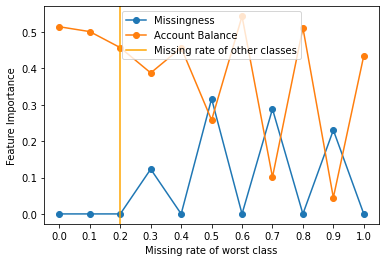

In [18]:
def missingness_vs_imps(col_name, vals, freq, missingness_val, vol_idx):
    # reading in data again each time is necessary because function "create missingness" needs un-normalized data
    xs, ys = read_data()
    accuracies = []
    missingness_imps = []
    vol_feat_imps = []
    for i in range(0, 11):
        missing_rate = i/10
        freq[vol_idx] = missing_rate
        xs_vol = create_missingness(xs, col_name, vals, freq, missingness_val)
        if np.max(freq) == 0:
            xs_vol[col_name + " Missing"] = xs_vol[col_name].apply(lambda x: 0)
        d_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
        cross_val = cross_validate(d_tree, xs_vol.values, ys.values, cv=10, return_estimator=True)
        temp_missing = []
        temp_vol = []
        for model in cross_val["estimator"]:
            temp_missing.append(model.feature_importances_[xs_vol.columns.get_loc(col_name + " Missing")])
            temp_vol.append(model.feature_importances_[xs_vol.columns.get_loc(col_name)])
            if 2 < model.feature_importances_[xs_vol.columns.get_loc(col_name)]:
                plt.figure(figsize=(cm_to_inch(150), cm_to_inch(150)))
                tree.plot_tree(model, feature_names=xs_acc.columns, class_names=["not credible", "credible"])
                plt.savefig("plots/d_tree_acc_dropped.png", dpi=150)#, bbox_inches="tight")
                plt.show()
            """
            if model.feature_importances_[xs_vol.columns.get_loc(col_name + " Missing")] > model.feature_importances_[xs_vol.columns.get_loc(col_name)]:
                plt.figure(figsize=(cm_to_inch(150), cm_to_inch(150)))
                tree.plot_tree(model, feature_names=xs_acc.columns, class_names=["not credible", "credible"])
                plt.savefig("plots/d_tree_acc_dropped.png", dpi=150)#, bbox_inches="tight")
                plt.show()
            """
        missingness_imps.append(cross_val["estimator"][0].feature_importances_[xs_vol.columns.get_loc(col_name + " Missing")])
        #missingness_imps.append(np.mean(temp_missing))
        vol_feat_imps.append(np.mean(temp_vol))

    #print("Accuracies:", accuracies)
    #print("Missingness Coefs:",missingness_coefs)
    print(missingness_imps)
    plt.plot(np.linspace(0, 1, 11), missingness_imps, 'o-', label='Missingness')
    plt.plot(np.linspace(0, 1, 11), vol_feat_imps, 'o-', label=col_name)
    plt.axvline(0.2, color="orange", label="Missing rate of other classes")
    plt.xlabel("Missing rate of worst class")
    plt.ylabel("Feature Importance")
    plt.xticks(np.linspace(0, 1, 11))
    plt.legend(loc='best')
    #plt.show()
    plt.savefig("plots/featimps_vs_missing.png", dpi=250)

        
#missingness_vs_coefs("Sex", [-1, 1], [0, 0], 0, 1)
missingness_vs_imps("Account Balance", [1,2,3,4], [0.2,0.2,0.2,0.2], "random", 0)

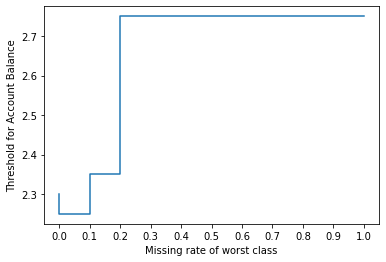

In [12]:
def missingness_vs_threshold(col_name, vals, freq, missingness_val, vol_idx):
    # reading in data again each time is necessary because function "create missingness" needs un-normalized data
    xs, ys = read_data()

    threshs = []
    for i in range(0, 11):
        missing_rate = i/10
        freq[vol_idx] = missing_rate
        xs_vol = create_missingness(xs, col_name, vals, freq, missingness_val)
        if np.max(freq) == 0:
            xs_vol[col_name + " Missing"] = xs_vol[col_name].apply(lambda x: 0)
        d_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
        cross_val = cross_validate(d_tree, xs_vol.values, ys.values, cv=10, return_estimator=True)
        """
        plt.figure(figsize=(cm_to_inch(150), cm_to_inch(150)))
        tree.plot_tree(cross_val["estimator"][0], feature_names=xs_acc.columns, class_names=["not credible", "credible"])
        plt.show()
        print(cross_val["estimator"][0].tree_.threshold[0])
        """
        temp_thresh = []
        for model in cross_val["estimator"]:
            temp_thresh.append(model.tree_.threshold[0])
        threshs.append(np.mean(temp_thresh))

    plt.plot(np.linspace(0, 1, 11), threshs, drawstyle="steps")
    plt.xlabel("Missing rate of worst class")
    plt.ylabel("Threshold for Account Balance")
    plt.xticks(np.linspace(0, 1, 11))
    #plt.legend(loc='best')
    plt.show()
    #plt.savefig("plots/featimps_vs_missing.png", dpi=250)
#cross_val_acc["estimator"][0].tree_.threshold[0]
missingness_vs_threshold("Account Balance", [1,2,3,4], [0.2,0.2,0.2,0.2], "class_avg", 0)